<a href="https://colab.research.google.com/github/mildsupitcha25/MachineLearning_phishing_email/blob/main/ML_Phishing_Email_Project_Final_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== Evaluation Summary (Test Set) ===


,Model,Threshold,ROC-AUC,PR-AUC,Accuracy,Precision,Recall,F1
0,XGBoost,0.802311,0.982249,0.983826,0.884615,0.916667,0.846154,0.880000
1,SVM,0.739601,0.976331,0.975185,0.884615,0.916667,0.846154,0.880000
2,CatBoost,0.920338,0.976331,0.979660,0.884615,0.916667,0.846154,0.880000
3,Logistic,0.586849,0.958580,0.949330,0.884615,0.916667,0.846154,0.880000
4,RandomForest,0.585000,0.946746,0.934434,0.846154,0.909091,0.769231,0.833333



=== Confusion Matrices (Test Set) ===

Logistic


,Pred_Legitimate,Pred_Phishing
Actual_Legitimate,12,1
Actual_Phishing,2,11


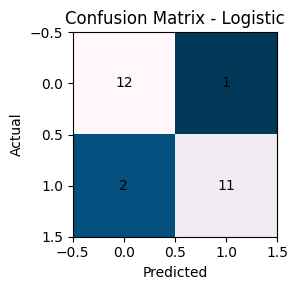


SVM


,Pred_Legitimate,Pred_Phishing
Actual_Legitimate,12,1
Actual_Phishing,2,11


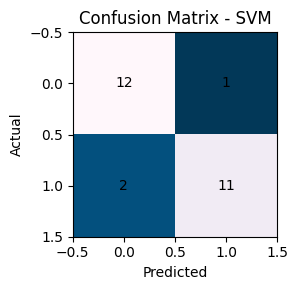


RandomForest


,Pred_Legitimate,Pred_Phishing
Actual_Legitimate,12,1
Actual_Phishing,3,10


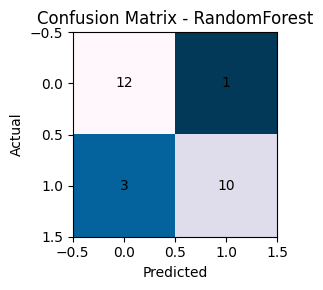


XGBoost


,Pred_Legitimate,Pred_Phishing
Actual_Legitimate,12,1
Actual_Phishing,2,11


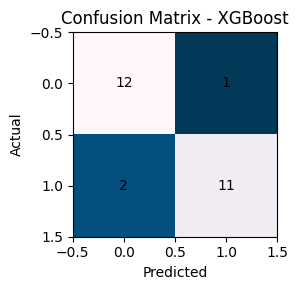


CatBoost


,Pred_Legitimate,Pred_Phishing
Actual_Legitimate,12,1
Actual_Phishing,2,11


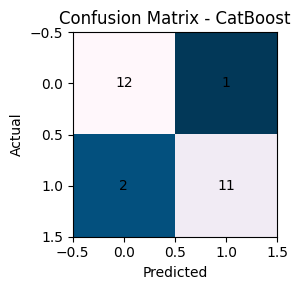

In [12]:
# ==============================
# Pipeline
# ==============================

!pip -q install xgboost catboost optuna

import warnings, optuna
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve,
    fbeta_score, average_precision_score, confusion_matrix
)
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# ==============================
# Load data
# ==============================
TRAIN_URL = "https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv"
TEST_URL  = "https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv"

train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

train_df["FullText"] = train_df["Subject"].fillna("") + " " + train_df["Body"].fillna("")
test_df["FullText"]  = test_df["Subject"].fillna("") + " " + test_df["Body"].fillna("")

label_map = {"Legitimate": 0, "Phishing": 1}
train_df["label_num"] = train_df["Label"].map(label_map)
test_df["label_num"]  = test_df["Label"].map(label_map)

y = train_df["label_num"].values
y_test = test_df["label_num"].values


# ==============================
# TF-IDF
# ==============================
word_vec = TfidfVectorizer(
    stop_words="english", ngram_range=(1,2), max_features=20000
)

char_vec = TfidfVectorizer(
    analyzer="char", ngram_range=(3,5), max_features=15000
)

Xw = word_vec.fit_transform(train_df["FullText"])
Xc = char_vec.fit_transform(train_df["FullText"])
X_all = hstack([Xw, Xc]).tocsr()

Xw_test = word_vec.transform(test_df["FullText"])
Xc_test = char_vec.transform(test_df["FullText"])
X_test_all = hstack([Xw_test, Xc_test]).tocsr()


# ==============================
# Train / Validation split
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y, test_size=0.2, stratify=y, random_state=42
)

# ==============================
# Threshold tuning
# ==============================
def tune_threshold(y_true, prob, target_recall=0.95):
    prec, rec, thr = precision_recall_curve(y_true, prob)
    best_t, best_p = None, -1
    for p, r, t in zip(prec[:-1], rec[:-1], thr):
        if r >= target_recall and p > best_p:
            best_p, best_t = p, t
    if best_t is not None:
        return best_t
    thresholds = np.linspace(0.05, 0.95, 91)
    f2s = [fbeta_score(y_true, (prob>=t).astype(int), beta=2) for t in thresholds]
    return float(thresholds[np.argmax(f2s)])

# ==============================
# Models
# ==============================
final_models = {}
model_thresholds = {}

# Logistic
rs = RandomizedSearchCV(
    LogisticRegression(solver="saga", class_weight="balanced", max_iter=5000, random_state=42),
    {"C": np.logspace(-1, 1, 7)},
    n_iter=4, scoring="recall", cv=3, n_jobs=-1, random_state=42
)
rs.fit(X_tr, y_tr)
best_log = rs.best_estimator_
thr = tune_threshold(y_val, best_log.predict_proba(X_val)[:,1])
final_models["Logistic"] = LogisticRegression(
    solver="saga", class_weight="balanced", max_iter=5000,
    C=rs.best_params_["C"], random_state=42
).fit(X_all, y)
model_thresholds["Logistic"] = thr

# SVM
svm_val = CalibratedClassifierCV(LinearSVC(class_weight="balanced", random_state=42), cv=3)
svm_val.fit(X_tr, y_tr)
thr = tune_threshold(y_val, svm_val.predict_proba(X_val)[:,1])
final_models["SVM"] = CalibratedClassifierCV(
    LinearSVC(class_weight="balanced", random_state=42), cv=3
).fit(X_all, y)
model_thresholds["SVM"] = thr

# RandomForest
rs_rf = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42),
    {"n_estimators":[100,200], "max_depth":[8,12]},
    n_iter=3, scoring="recall", cv=3, n_jobs=-1, random_state=42
)
rs_rf.fit(X_tr, y_tr)
best_rf = rs_rf.best_estimator_
thr = tune_threshold(y_val, best_rf.predict_proba(X_val)[:,1])
final_models["RandomForest"] = RandomForestClassifier(
    **rs_rf.best_params_, class_weight="balanced", n_jobs=-1, random_state=42
).fit(X_all, y)
model_thresholds["RandomForest"] = thr

# Naive Bayes
'''nb = MultinomialNB()
nb.fit(X_tr, y_tr)
thr = tune_threshold(y_val, nb.predict_proba(X_val)[:,1])
final_models["NaiveBayes"] = MultinomialNB().fit(X_all, y)
model_thresholds["NaiveBayes"] = thr'''

# XGBoost
xgb = XGBClassifier(
    n_estimators=180, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="auc", tree_method="hist", random_state=42
)
xgb.fit(X_tr, y_tr)
thr = tune_threshold(y_val, xgb.predict_proba(X_val)[:,1])
final_models["XGBoost"] = XGBClassifier(**xgb.get_params()).fit(X_all, y)
model_thresholds["XGBoost"] = thr

# CatBoost
cb = CatBoostClassifier(
    iterations=300, depth=6, learning_rate=0.05,
    loss_function="Logloss", verbose=False, random_state=42
)
cb.fit(X_tr, y_tr)
thr = tune_threshold(y_val, cb.predict_proba(X_val)[:,1])
final_models["CatBoost"] = CatBoostClassifier(**cb.get_params()).fit(X_all, y)
model_thresholds["CatBoost"] = thr


# ======================
# TEST EVALUATION + CONFUSION MATRICES
# ======================

rows = []
pred_df = pd.DataFrame()

for name, model in final_models.items():
    # Predict probability & apply tuned threshold
    prob = model.predict_proba(X_test_all)[:, 1]
    thr = model_thresholds[name]
    pred = (prob >= thr).astype(int)

    # Store predictions
    pred_df[f"{name}_prob"] = prob
    pred_df[f"{name}_pred"] = pred

    # Collect metrics
    rows.append({
        "Model": name,
        "Threshold": thr,
        "ROC-AUC": roc_auc_score(y_test, prob),
        "PR-AUC": average_precision_score(y_test, prob),
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred)
    })

# ===== Summary Table =====
results_df = (
    pd.DataFrame(rows)
    .sort_values("ROC-AUC", ascending=False)
    .reset_index(drop=True)
)

print("\n=== Evaluation Summary (Test Set) ===")
display(results_df)

# ===== Confusion Matrices =====
print("\n=== Confusion Matrices (Test Set) ===")

for name in final_models.keys():
    cm = confusion_matrix(y_test, pred_df[f"{name}_pred"])

    cm_df = pd.DataFrame(
        cm,
        index=["Actual_Legitimate", "Actual_Phishing"],
        columns=["Pred_Legitimate", "Pred_Phishing"]
    )

    print(f"\n{name}")
    display(cm_df)

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, cmap="PuBu_r")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.tight_layout()
    plt.show()



In [7]:

import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go

# --------------------------------------------------
# 0) เลือกชุดทดสอบให้ตรงกับ pipeline ของคุณ
# --------------------------------------------------
X_te = X_test_all      # <-- ถ้าคุณรวม Word2Vec: เปลี่ยนเป็น X_test_all_ext
y_te = y_test

# --------------------------------------------------
# 1) แปลง y_test เป็น binary (0/1) และเลือก positive class
# --------------------------------------------------
def make_binary_y(y_true):
    y = pd.Series(y_true)
    lower = y.astype(str).str.lower()
    mask_phish = lower.str.contains("phish")
    if mask_phish.any():
        pos_name = lower[mask_phish].iloc[0]
        y_bin = (lower == pos_name).astype(int).values
        pos_label = 1
        pos_display = y[mask_phish].iloc[0]
    else:
        le = LabelEncoder()
        y_bin = le.fit_transform(y)
        pos_label = 1
        pos_display = le.classes_[pos_label] if hasattr(le, "classes_") else "positive"
    return y_bin, pos_label, pos_display

y_te_bin, POS_LABEL, POS_NAME = make_binary_y(y_te)
print(f"Positive class สำหรับ ROC: '{POS_NAME}' (เข้ารหัสเป็น {POS_LABEL})")

# --------------------------------------------------
# 2) ดึงคะแนนของ positive class สำหรับ ROC
# --------------------------------------------------
def get_positive_scores(model, X, pos_label=1):
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        if hasattr(model, "classes_") and len(getattr(model, "classes_")) >= 2:
            classes = list(model.classes_)
            try:
                idx = classes.index(pos_label)
            except ValueError:
                idx = 1  # fallback: ใช้คอลัมน์ที่ 1 สำหรับ binary
            return proba[:, idx]
        return proba[:, -1]  # fallback
    if hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return scores.ravel()
    return model.predict(X)  # fallback (0/1)

# --------------------------------------------------
# 3) พล็อต ROC ทีละโมเดลด้วย Plotly
# --------------------------------------------------

import plotly.graph_objects as go

def plot_roc_single_plotly(estimator, X_test, y_test_bin, pos_label=1, name="Model",
                           tuned_thr=None, show_threshold_marker=True):
    # คำนวณ ROC / AUC
    y_score = get_positive_scores(estimator, X_test, pos_label=pos_label)
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_score, pos_label=pos_label)
    auc_val = roc_auc_score(y_test_bin, y_score)

    # สี/สไตล์ที่เข้มและชัด
    ROC_COLOR = "#0B3D91"          # น้ำเงินเข้ม
    BASELINE_COLOR = "#444444"     # เทาเข้ม
    GRID_COLOR = "rgba(0,0,0,0.15)"

    fig = go.Figure()

    # เส้น ROC (เข้ม + หนา)
    fig.add_trace(go.Scatter(
        x=fpr, y=tpr, mode="lines",
        name=f"AUC = {auc_val:.3f}",
        line=dict(color=ROC_COLOR, width=5),     # << เส้นหนา
        hovertemplate="<b>FPR:</b> %{x:.4f}<br><b>TPR:</b> %{y:.4f}<extra></extra>"
    ))

    # เส้น baseline (สุ่ม) — เส้นประเทาเข้ม + หนาขึ้น
    fig.add_trace(go.Scatter(
        x=[0, 1], y=[0, 1], mode="lines",
        name="สุ่ม (AUC = 0.500)",
        line=dict(color=BASELINE_COLOR, dash="dash", width=3),
        hovertemplate="<b>FPR:</b> %{x:.4f}<br><b>TPR:</b> %{y:.4f}<extra></extra>"
    ))

    # จุด threshold (เด่นขึ้น: สีแดง เข็ม–ใหญ่ พร้อม label)
    if show_threshold_marker and tuned_thr is not None and len(thresholds) > 0:
        import numpy as np
        idx = int(np.argmin(np.abs(thresholds - tuned_thr)))
        fig.add_trace(go.Scatter(
            x=[fpr[idx]], y=[tpr[idx]],
            mode="markers+text",
            name=f"threshold≈{tuned_thr:.3f}",
            marker=dict(color="red", size=12, symbol="circle", line=dict(color="black", width=1)),
            text=[f"thr≈{tuned_thr:.3f}"],
            textfont=dict(color="black", size=14, family="Arial Black"),
            textposition="top center",
            hovertemplate=(
                "<b>threshold≈</b>%{text}<br>"
                f"<b>AUC:</b> {auc_val:.3f}<br>"
                "<b>FPR:</b> %{x:.4f}<br><b>TPR:</b> %{y:.4f}<extra></extra>"
            )
        ))

    # Layout: ตัวหนังสือ "ตัวหนา สีดำ" ทั้งหมด + กริดเข้มขึ้น
    fig.update_layout(
        title=dict(text=f"ROC: {name}", font=dict(size=22, family="Arial Black", color="black")),
        xaxis_title="อัตราบวกเทียม (FPR)",
        yaxis_title="อัตราบวกแท้ (TPR)",
        xaxis=dict(range=[0, 1], showgrid=True, gridcolor=GRID_COLOR, zeroline=True, zerolinecolor="#222"),
        yaxis=dict(range=[0, 1], showgrid=True, gridcolor=GRID_COLOR, zeroline=True, zerolinecolor="#222"),
        legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99,
                    font=dict(size=14, family="Arial Black", color="black")),
        template="plotly_white",
        width=820, height=540,
        font=dict(size=14, family="Arial Black", color="black"),  # ตัวหนังสือทั่วกราฟ
    )

    # ทำ hover label ให้โทนเข้ม
    fig.update_traces(hoverlabel=dict(bgcolor="rgba(255,255,255,0.95)",
                                      font=dict(color="black", size=13, family="Arial Black")))

    fig.show()
    print(f"{name}: AUC = {auc_val:.4f}")
    return fig, auc_val


# --------------------------------------------------
# 4) เรียกพล็อตตาม final_models ของคุณ (หนึ่งกราฟต่อหนึ่งโมเดล)
# --------------------------------------------------
for model_name, estimator in final_models.items():
    tuned_thr = model_thresholds.get(model_name, None)
    _fig, _auc = plot_roc_single_plotly(
        estimator, X_te, y_te_bin, pos_label=POS_LABEL,
        name=model_name, tuned_thr=tuned_thr, show_threshold_marker=True
    )


Positive class สำหรับ ROC: '1' (เข้ารหัสเป็น 1)


Logistic: AUC = 0.9586


SVM: AUC = 0.9763


RandomForest: AUC = 0.9467


XGBoost: AUC = 0.9822


CatBoost: AUC = 0.9763
